In [1]:
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import fsspec
import s3fs
import os
import ujson
from pathlib import Path
import xarray as xr
import cf_xarray
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy

In [2]:
%%time
fs = fsspec.filesystem("reference", fo='s3://noaa3100-oar-pmel-dev-cefi/ne_pacific_10km/json/combined.json', 
                       remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")
d = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={'ocean_time':1})
d

NoCredentialsError: Unable to locate credentials

In [3]:
fs2 = fsspec.filesystem("reference", fo='s3://noaa3100-oar-pmel-dev-cefi/ne_pacific_10km/json/roms_grd_nep.json', 
                       remote_protocol='s3', remote_options={'anon':True})
m2 = fs2.get_mapper("")
grd = xr.open_dataset(m2, engine="zarr", backend_kwargs={'consolidated':False})
grd

<xarray.Dataset> Size: 43MB
Dimensions:    (two: 2, eta_rho: 642, xi_rho: 226, bath: 9, eta_psi: 641,
                xi_psi: 225, eta_u: 642, xi_u: 225, eta_v: 641, xi_v: 226,
                ncl11: 642, ncl12: 226)
Dimensions without coordinates: two, eta_rho, xi_rho, bath, eta_psi, xi_psi,
                                eta_u, xi_u, eta_v, xi_v, ncl11, ncl12
Data variables: (12/47)
    JLTS       (two) |S1 2B ...
    JPRJ       (two) |S1 2B ...
    P1         float32 4B ...
    P2         float32 4B ...
    P3         float32 4B ...
    P4         float32 4B ...
    ...         ...
    x_v        (eta_v, xi_v) float64 1MB ...
    xl         float64 8B ...
    y_psi      (eta_psi, xi_psi) float64 1MB ...
    y_rho      (eta_rho, xi_rho) float64 1MB ...
    y_u        (eta_u, xi_u) float64 1MB ...
    y_v        (eta_v, xi_v) float64 1MB ...
Attributes:
    CPP-options:  DCOMPLEX, DBLEPREC, ETOPO5, DRAW_COASTS, KEEP_SHALLOW, PLOTS,
    gridid:       Northeast Pacific #4
    history:      Gridpak, Version 5.3  , Tuesday - February 15, 2005 - 2:42:...
    type:         Gridpak file

In [4]:
ds = xr.merge([d,grd])
ds

<xarray.Dataset> Size: 9GB
Dimensions:      (ocean_time: 12, s_w: 43, eta_rho: 642, xi_rho: 226,
                  tracer: 13, s_rho: 42, boundary: 4, eta_u: 642, xi_u: 225,
                  eta_v: 641, xi_v: 226, two: 2, bath: 9, eta_psi: 641,
                  xi_psi: 225, ncl11: 642, ncl12: 226)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 96B 2020-01-16 ... 2020-12-16
  * s_rho        (s_rho) float64 336B -0.9881 -0.9643 ... -0.03571 -0.0119
  * s_w          (s_w) float64 344B -1.0 -0.9762 -0.9524 ... -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, tracer, boundary, eta_u, xi_u,
                                eta_v, xi_v, two, bath, eta_psi, xi_psi, ncl11,
                                ncl12
Data variables: (12/137)
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    AKv          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    Akt_bak      (ocean_time, tracer) float64 1kB dask.array<chunksize=(1, 13), meta=np.ndarray>
    Akv_bak      (ocean_time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    CChl_PhL     (ocean_time, s_rho, eta_rho, xi_rho) float32 293MB dask.array<chunksize=(1, 42, 642, 226), meta=np.ndarray>
    ...           ...
    x_u          (eta_u, xi_u) float64 1MB ...
    x_v          (eta_v, xi_v) float64 1MB ...
    y_psi        (eta_psi, xi_psi) float64 1MB ...
    y_rho        (eta_rho, xi_rho) float64 1MB ...
    y_u          (eta_u, xi_u) float64 1MB ...
    y_v          (eta_v, xi_v) float64 1MB ...
Attributes: (12/47)
    CPP_options:               NEP, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSF...
    Conventions:               CF-1.0
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    ana_file:                  ROMS/Functionals/ana_btflux.h, Apps/NEP/ana_hm...
    avg_base:                  /gscratch/goaclim/hermann/NEP_OUTPUT/hind/hind...
    bio_file:                  ----------------------------------------------...
    ...                        ...
    svn_rev:                   Unversioned directory
    svn_url:                   https://www.myroms.org/svn/omlab/branches/kate
    tiling:                    008x024
    title:                     Northeast Pacific 10km Grid
    type:                      ROMS/TOMS averages file
    var_info:                  /gscratch/goaclim/hermann/Ken_CGOA/CGOA_Model/...

In [5]:
ds = ds.assign_coords(latitude=ds.lat_rho, longitude=ds.lon_rho)
ds

<xarray.Dataset> Size: 9GB
Dimensions:      (ocean_time: 12, s_w: 43, eta_rho: 642, xi_rho: 226,
                  tracer: 13, s_rho: 42, boundary: 4, eta_u: 642, xi_u: 225,
                  eta_v: 641, xi_v: 226, two: 2, bath: 9, eta_psi: 641,
                  xi_psi: 225, ncl11: 642, ncl12: 226)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 96B 2020-01-16 ... 2020-12-16
  * s_rho        (s_rho) float64 336B -0.9881 -0.9643 ... -0.03571 -0.0119
  * s_w          (s_w) float64 344B -1.0 -0.9762 -0.9524 ... -0.02381 0.0
    latitude     (eta_rho, xi_rho) float64 1MB ...
    longitude    (eta_rho, xi_rho) float64 1MB ...
Dimensions without coordinates: eta_rho, xi_rho, tracer, boundary, eta_u, xi_u,
                                eta_v, xi_v, two, bath, eta_psi, xi_psi, ncl11,
                                ncl12
Data variables: (12/137)
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    AKv          (ocean_time, s_w, eta_rho, xi_rho) float32 299MB dask.array<chunksize=(1, 43, 642, 226), meta=np.ndarray>
    Akt_bak      (ocean_time, tracer) float64 1kB dask.array<chunksize=(1, 13), meta=np.ndarray>
    Akv_bak      (ocean_time) float64 96B dask.array<chunksize=(1,), meta=np.ndarray>
    CChl_PhL     (ocean_time, s_rho, eta_rho, xi_rho) float32 293MB dask.array<chunksize=(1, 42, 642, 226), meta=np.ndarray>
    ...           ...
    x_u          (eta_u, xi_u) float64 1MB ...
    x_v          (eta_v, xi_v) float64 1MB ...
    y_psi        (eta_psi, xi_psi) float64 1MB ...
    y_rho        (eta_rho, xi_rho) float64 1MB ...
    y_u          (eta_u, xi_u) float64 1MB ...
    y_v          (eta_v, xi_v) float64 1MB ...
Attributes: (12/47)
    CPP_options:               NEP, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSF...
    Conventions:               CF-1.0
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    ana_file:                  ROMS/Functionals/ana_btflux.h, Apps/NEP/ana_hm...
    avg_base:                  /gscratch/goaclim/hermann/NEP_OUTPUT/hind/hind...
    bio_file:                  ----------------------------------------------...
    ...                        ...
    svn_rev:                   Unversioned directory
    svn_url:                   https://www.myroms.org/svn/omlab/branches/kate
    tiling:                    008x024
    title:                     Northeast Pacific 10km Grid
    type:                      ROMS/TOMS averages file
    var_info:                  /gscratch/goaclim/hermann/Ken_CGOA/CGOA_Model/...

In [6]:
xmin = ds.lon_rho.min().item()
xmax = ds.cf['longitude'].max().item()
ymin = ds.cf['latitude'].min().item()
ymax = ds.lat_rho.max().item()
xmin, xmax, ymin, ymax

(145.79670206769543, 247.64488747492456, 20.633965725936278, 71.60469093729232)

In [7]:
slice=ds['salt'].sel(ocean_time='2020-01-16', s_rho=-0.0119, method='nearest')
slice

<xarray.DataArray 'salt' (eta_rho: 642, xi_rho: 226)> Size: 580kB
dask.array<getitem, shape=(642, 226), dtype=float32, chunksize=(642, 226), chunktype=numpy.ndarray>
Coordinates:
    ocean_time  datetime64[ns] 8B 2020-01-16
    s_rho       float64 8B -0.0119
    latitude    (eta_rho, xi_rho) float64 1MB 20.63 20.69 20.75 ... 71.06 71.15
    longitude   (eta_rho, xi_rho) float64 1MB 227.0 227.1 227.2 ... 145.9 145.8
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    cell_methods:  ocean_time: mean
    field:         salinity, scalar, series
    long_name:     time-averaged salinity
    time:          ocean_time

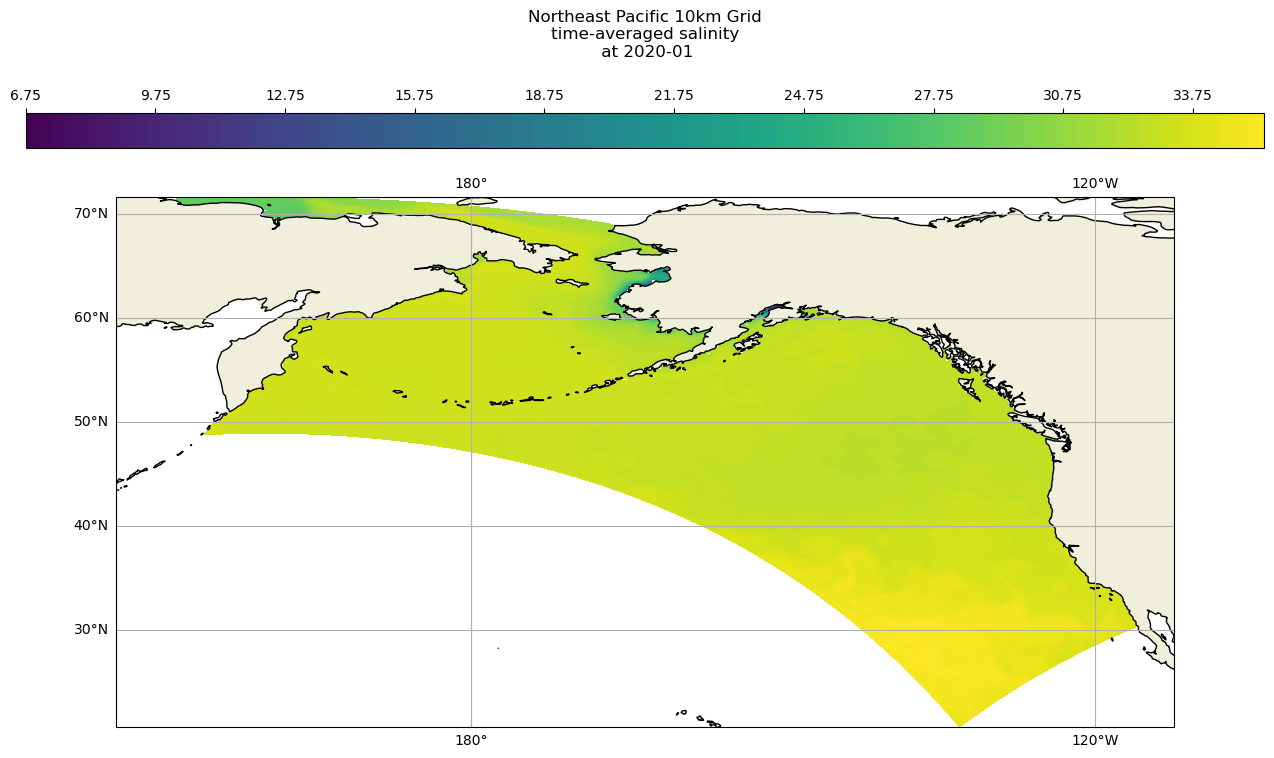

In [8]:
title_date='2020-01'
aspect = (xmax - xmin)/(ymax-ymin)
plt.figure(figsize=(8*aspect,8))
proj = ccrs.PlateCarree(central_longitude=180)
proj180 = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent([xmin, xmax, ymin, ymax], crs=proj180)
# add some features to make the map a little more polished
ax.add_feature(cartopy.feature.LAND)
# ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines('50m')
gl = ax.gridlines(draw_labels=True)
ct = ax.contourf(ds.cf['longitude'], ds.cf['latitude'], slice, levels=255, transform=proj180)
plt.colorbar(ct, orientation='horizontal',pad=0.08, aspect=35, fraction=.06, location='top')
plt.title(ds.attrs['title'] + '\n' + slice.attrs['long_name'] + '\n at ' + title_date , y=1.25)
plt.show()